## General Model



## Import useful packages

In [39]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import boto3
import io
from keras.utils import plot_model
import random



## Define functions to load the data


#### This code gets list of keys (ie files) in S3 bucket
(Should consider moving this into a helper file.)

In [40]:
def get_matching_s3_objects(bucket, prefix="", suffix=""):
    """
    Generate objects in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch objects whose key starts with
        this prefix (optional).
    :param suffix: Only fetch objects whose keys end with
        this suffix (optional).
    """
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")

    kwargs = {'Bucket': bucket}

    # We can pass the prefix directly to the S3 API.  If the user has passed
    # a tuple or list of prefixes, we go through them one by one.
    if isinstance(prefix, str):
        prefixes = (prefix, )
    else:
        prefixes = prefix

    for key_prefix in prefixes:
        kwargs["Prefix"] = key_prefix

        for page in paginator.paginate(**kwargs):
            try:
                contents = page["Contents"]
            except KeyError:
                break

            for obj in contents:
                key = obj["Key"]
                if key.endswith(suffix):
                    yield obj


def get_matching_s3_keys(bucket, prefix="", suffix=""):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    obj_list=[]
    for obj in get_matching_s3_objects(bucket, prefix, suffix):
        obj_list.append(obj["Key"])
    return(obj_list)


### Key image read-in functions: load_image and build_input

In [41]:
def load_image(s3_client,bucket_name,file_name, dim=(224,224)):
    """
    Loads a single image as a Numpy array and resizes it as
    desired.  The default dimensions are consistent with
    those expected by the VGG models.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_name:  file to convert to image

    dim: Two-element tuple giving the desired height
         and width of the processed image

    Returns:
    image:  A single-channel Numpy array
    """
    #image = cv2.imread(image_path, 0)
    file_stream = io.BytesIO()
    s3.download_fileobj(bucket_name,file_name,file_stream)
    nparr = np.frombuffer(file_stream.getvalue(), np.uint8)
    image=cv2.imdecode(nparr,0)
    image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
    return image

In [47]:
def build_input(s3_client,bucket_name,file_list,files_to_load):
    """
    Loads all of the images into a single numpy array.
    Assumes that there are 101 equally-spaced images
    spanning lattitudes from 35N to 45N.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_list:  list of files in bucket
    Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.

    y:  A 1-dimensional numpy array of target lattitudes.
    """
    X = []
    i=0
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            print(file)
            image = load_image(s3_client,bucket_name,file)
            X.append(image)
            if i%100==0:
                print('loaded:',i)
            i+=1
    return (np.array(X) / 255)

In [48]:
def build_labels(file_list,files_to_load):
    y = []
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            file_split = file.split('+')
            lat = float(file_split[0])
            long = float(file_split[1])
            y.append((lat, long))
    return np.array(y)

#### Test load_image on one image manually

(224, 224)


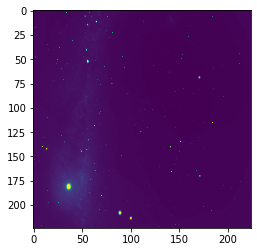

In [49]:
bucket_name='w251-final-project'
file_name='31.4649478225928+-61.88337836181259+2020-07-04T01:00:00.png'
s3 = boto3.client('s3')
sample_image = load_image(s3,bucket_name,file_name)
plt.imshow(sample_image)
print(sample_image.shape)

## Prepare the data

### Load the images

In [52]:
#clear out models for memory management purposes
tf.keras.backend.clear_session()

#change this to true to force it to reload from S3 bucket
force_load=True

#check if np arrays have already been saved and load if so
if ((os.path.exists('x.npy'))&(not force_load)):
    print('loading from files')
    X=np.load('x.npy')
    y=np.load('y.npy')

#otherwise go to S3 bucket
else:
    print('loading from S3')
    bucket_name='w251-final-project'
    file_list=get_matching_s3_keys(bucket_name)
    
    #shuffle file list so that if take less than all are distributed.  also makes array randomly shuffled
    random.shuffle(file_list)
    
    s3 = boto3.client('s3')

    #max_files=100000
    max_files=5000
    file_list_length=len(file_list)
    files_to_load=np.minimum(max_files,file_list_length)

    #get images
    print('about to call build_input on',files_to_load,' files')
    X = build_input(s3,bucket_name,file_list,files_to_load)


    #get labels
    print ('building labels')
    y = build_labels(file_list,files_to_load)
    
    print ('saving arrays so can reload more easily next time through')
    np.save('x.npy',X)
    np.save('y.npy',y)

print ('shape of image array:', X.shape)
print ('shape of label list:', y.shape)

loading from S3
about to call build_input on 660  files
45.51824359790318+-61.993845329152215+2020-07-04T01:00:00.png
loaded: 0
33.8438901664736+-59.78445466865381+2020-07-04T01:00:00.png
39.91971850660452+-68.71180698854408+2020-07-04T01:00:00.png
41.79941544939069+-57.47018525484641+2020-07-04T01:00:00.png
40.39314089777557+-65.47140950090719+2020-07-04T01:00:00.png
44.13621359771078+-68.81802468071767+2020-07-04T01:00:00.png
42.58042176881449+-67.31572231501379+2020-07-04T01:00:00.png
34.6529969841322+-66.48415020094794+2020-07-04T01:00:00.png
45.38134886523299+-61.260355655741776+2020-07-04T01:00:00.png
41.24456431627196+-58.026133109564796+2020-07-04T01:00:00.png
31.9867208591466+-53.62415685703807+2020-07-04T01:00:00.png
38.46269759811392+-56.37114262315416+2020-07-04T01:00:00.png
38.07689769003228+-56.07262295581776+2020-07-04T01:00:00.png
33.022239981481654+-68.6054621905236+2020-07-04T01:00:00.png
48.5409764329287+-55.83079847071735+2020-07-04T01:00:00.png
38.05584428683948+-5

46.875689824825535+-67.28619614748463+2020-07-04T01:00:00.png
31.98565684029824+-58.215419876352314+2020-07-04T01:00:00.png
34.74879214177284+-57.33817790007993+2020-07-04T01:00:00.png
31.4587207293346+-67.85852619594864+2020-07-04T01:00:00.png
37.20961167929816+-69.93884414552097+2020-07-04T01:00:00.png
37.824162372923254+-68.15539022042655+2020-07-04T01:00:00.png
31.47802154628327+-64.78532963147389+2020-07-04T01:00:00.png
48.87658343202536+-61.71188256365021+2020-07-04T01:00:00.png
31.943860168447785+-68.54238599680521+2020-07-04T01:00:00.png
36.002749018240465+-63.241710602653455+2020-07-04T01:00:00.png
45.38171005389778+-54.77911111279912+2020-07-04T01:00:00.png
47.50133766542667+-63.97992178847491+2020-07-04T01:00:00.png
30.234849584397587+-52.195741951174924+2020-07-04T01:00:00.png
31.050511921308+-58.2586300634445+2020-07-04T01:00:00.png
32.62880826793623+-59.61923371445511+2020-07-04T01:00:00.png
31.040313417983008+-61.785519707450476+2020-07-04T01:00:00.png
48.27509048633887+

45.293869532367886+-65.76525025113031+2020-07-04T01:00:00.png
37.96232628409286+-54.71083563756002+2020-07-04T01:00:00.png
37.57424521472311+-66.9261002645736+2020-07-04T01:00:00.png
41.36833938316928+-66.83886951371362+2020-07-04T01:00:00.png
40.48047621653635+-69.60233720940337+2020-07-04T01:00:00.png
47.72349045216233+-69.27814227440506+2020-07-04T01:00:00.png
37.36208852366287+-52.722678653089176+2020-07-04T01:00:00.png
49.8650143988758+-51.100060777931546+2020-07-04T01:00:00.png
47.11200217814047+-63.51625745682239+2020-07-04T01:00:00.png
48.125342395638356+-51.9756725808332+2020-07-04T01:00:00.png
33.42903104571136+-63.395292835959175+2020-07-04T01:00:00.png
39.235274025344154+-61.15625101899918+2020-07-04T01:00:00.png
35.05391062276676+-58.96920866463788+2020-07-04T01:00:00.png
47.68712118021124+-61.66446714672823+2020-07-04T01:00:00.png
47.44067138402892+-67.17471980920314+2020-07-04T01:00:00.png
38.93454600865713+-61.717000130600596+2020-07-04T01:00:00.png
41.05431224340074+-5

45.357466815355615+-69.4865126485693+2020-07-04T01:00:00.png
39.49298253154307+-54.86909626349116+2020-07-04T01:00:00.png
44.35762232941364+-62.592589125494875+2020-07-04T01:00:00.png
36.38682404068156+-54.3380519068887+2020-07-04T01:00:00.png
30.29155677531626+-55.71488005604556+2020-07-04T01:00:00.png
33.324179805199584+-62.7252150510561+2020-07-04T01:00:00.png
43.72666578441759+-69.40651495025037+2020-07-04T01:00:00.png
36.97678532529191+-63.9372111406258+2020-07-04T01:00:00.png
38.84087886004325+-54.68568888976816+2020-07-04T01:00:00.png
34.642015288457074+-52.11754689409328+2020-07-04T01:00:00.png
48.96799187045265+-50.200595075936164+2020-07-04T01:00:00.png
40.19374277372827+-65.34609972952681+2020-07-04T01:00:00.png
43.72587487711601+-67.09800453408664+2020-07-04T01:00:00.png
38.42721918745265+-61.13601029400517+2020-07-04T01:00:00.png
46.483361386898494+-61.44882242365354+2020-07-04T01:00:00.png
45.83091644959586+-59.20871322987223+2020-07-04T01:00:00.png
42.27758094492134+-52.

30.187682517654725+-60.699070325649686+2020-07-04T01:00:00.png
41.22005670586369+-66.96842059878168+2020-07-04T01:00:00.png
33.046646985090945+-63.31861752764124+2020-07-04T01:00:00.png
42.24893038499661+-52.01197160983134+2020-07-04T01:00:00.png
33.34572094990907+-51.532140480929016+2020-07-04T01:00:00.png
49.10876615973744+-66.62589783048107+2020-07-04T01:00:00.png
42.11160046633156+-62.32923533354918+2020-07-04T01:00:00.png
49.93283278906206+-66.35873827382443+2020-07-04T01:00:00.png
32.045414413285044+-67.05559659866324+2020-07-04T01:00:00.png
48.83155182039824+-54.88771486827549+2020-07-04T01:00:00.png
49.98571358036317+-66.69429656031896+2020-07-04T01:00:00.png
43.91459260503023+-64.8107297821658+2020-07-04T01:00:00.png
38.009649571039205+-65.70445841805544+2020-07-04T01:00:00.png
40.72384055918436+-65.04875719521503+2020-07-04T01:00:00.png
37.4769034674342+-64.45778519645994+2020-07-04T01:00:00.png
48.40492171687344+-61.791647700601025+2020-07-04T01:00:00.png
34.38913417242672+-


### Standardize the values

In [53]:
def scale_down(numbers):
    top=max(numbers)
    bottom=min(numbers)
    middle=(top+bottom)/2
    number_range=top-bottom
    revised=[x-middle for x in numbers]
    revised=[x/number_range*2 for x in revised]
    return revised,top,bottom

def scale_up(numbers,top,bottom):
    middle=(top+bottom)/2
    number_range=top-bottom
    revised=[x*number_range/2 for x in numbers]
    revised=[x+middle for x in revised]
    return revised

In [54]:
#just scaling down without normalizing
y[:,0],toplat,bottomlat=scale_down(y[:,0])
y[:,1],toplong,bottomlong=scale_down(y[:,1])

#y[:,0] = scale(y[:,0])
#y[:,1]=scale(y[:,1])

print (y[:,0].mean(),y[:,0].std())
print (y[:,1].mean(),y[:,1].std())

-0.015741246443521192 0.6059905369451217
-0.03653036415342433 0.562817668974893


### Split into test and training sets

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(528, 224, 224)
(528, 2)
(132, 224, 224)
(132, 2)


### Add channel for CNN

In [56]:
#need to add channel for B&W for CNN
#https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

print(X_train.shape,y_train.shape)
X_train=np.expand_dims(X_train,axis=3)
X_val=np.expand_dims(X_val,axis=3)
print(X_train.shape,X_val.shape)

(528, 224, 224) (528, 2)
(528, 224, 224, 1) (132, 224, 224, 1)


## The model

[]

In [88]:
tf.keras.backend.clear_session()

In [89]:
input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_uniform')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform')(x)
#x=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [90]:
print(model.summary())
#plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 128 1280        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 111, 111, 128 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 109, 109, 64) 73792       max_pooling2d[0][0]              
______________________________________________________________________________________________

### Fit the model

In [91]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=20, batch_size=128)

Train on 528 samples, validate on 132 samples
Epoch 1/20
528/528 [==============================] - 7s 12ms/sample - loss: 2.9599 - regression_lat_loss: 0.7175 - regression_long_loss: 1.8523 - regression_lat_mean_squared_error: 0.7673 - regression_long_mean_squared_error: 2.1925 - val_loss: 0.6541 - val_regression_lat_loss: 0.3768 - val_regression_long_loss: 0.2785 - val_regression_lat_mean_squared_error: 0.3571 - val_regression_long_mean_squared_error: 0.2970
Epoch 2/20
528/528 [==============================] - 6s 12ms/sample - loss: 0.6477 - regression_lat_loss: 0.3378 - regression_long_loss: 0.3002 - regression_lat_mean_squared_error: 0.3511 - regression_long_mean_squared_error: 0.2967 - val_loss: 0.5929 - val_regression_lat_loss: 0.3624 - val_regression_long_loss: 0.2721 - val_regression_lat_mean_squared_error: 0.3326 - val_regression_long_mean_squared_error: 0.2603
Epoch 3/20
528/528 [==============================] - 6s 12ms/sample - loss: 0.5138 - regression_lat_loss: 0.2789 - 

528/528 [==============================] - 6s 12ms/sample - loss: 0.1729 - regression_lat_loss: 0.0849 - regression_long_loss: 0.0768 - regression_lat_mean_squared_error: 0.0933 - regression_long_mean_squared_error: 0.0796 - val_loss: 0.4394 - val_regression_lat_loss: 0.2935 - val_regression_long_loss: 0.4182 - val_regression_lat_mean_squared_error: 0.2163 - val_regression_long_mean_squared_error: 0.2231


### Evaluate model performance

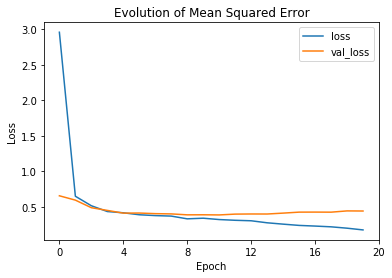

In [92]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [93]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

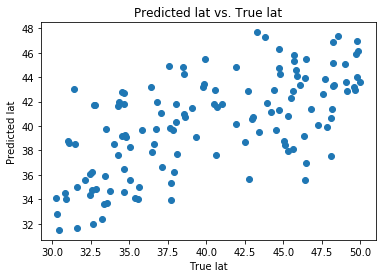

In [94]:
plt.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()

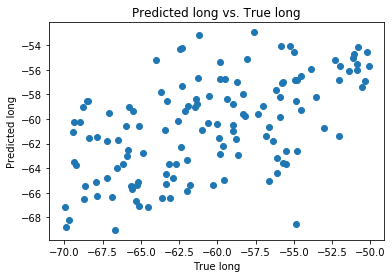

In [95]:
plt.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
plt.show()

### Things to consider doing:
- don't normalize the lat and long - just scale it DONE
- convert back to lat and long DONE
- set validation batch size to deal with OOM errors (possibly) DONE
- loss weights?
- what is resolution of png files coming in?  are they squares?
- since set wide rectangle, need to make sure entirely at night time


### Old models

In [ ]:
# Define Input layer(s)
inputShape = (224, 224)
inputs = tf.keras.layers.Input(shape=inputShape)

flatten = tf.keras.layers.Flatten()(inputs)

x=tf.keras.layers.Dense(512,activation='relu')(flatten)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)


# Build and compile model
model_input = inputs
model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(model_input, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2)
])